# B2A TIME-SERIES PREDICTION USING A MLP

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## Read data from excel file. 

In [2]:
data=pd.read_csv('./data_akbilgic_clean.csv', sep=';')

In [3]:
data

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...
525,0.005356,0.006886,0.004176,0.005425,0.006638,0.004140,0.006238,0.003980,-0.004499
526,0.004823,-0.003255,-0.002790,-0.000320,-0.006423,-0.001708,-0.023895,-0.003024,-0.014249
527,-0.017664,-0.024921,0.000749,0.002644,-0.005351,-0.001148,0.005590,-0.003742,-0.014760
528,0.004782,0.006418,0.005492,0.004204,0.007101,0.011241,0.018077,0.004727,0.003931


In [4]:
data.reset_index(inplace=True)#add index

In [5]:
data.head()

,index,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,0,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,1,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,3,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,4,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


## Plot the ISE feature.

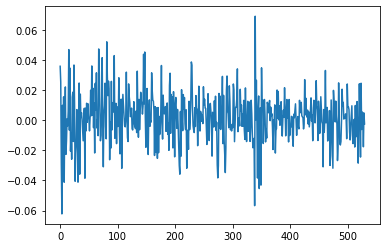

In [6]:
plt.plot(data['ISE'])
plt.savefig('./ise_plot.png')
plt.show()

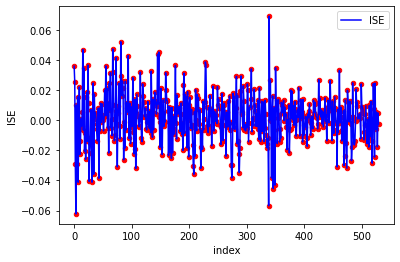

In [7]:
ax = plt.gca()
data.plot(kind='line', x=0,y=1, color='blue', ax=ax)
data.plot(kind='scatter', x=0,y=1, color='red', ax=ax)
plt.savefig('./ise_scatter_line_plot.png')
plt.show()

## Isolate ISE 

In [8]:
df = data['ISE'].to_frame(name='ISE')
df

,ISE
0,0.035754
1,0.025426
2,-0.028862
3,-0.062208
4,0.009860
...,...
525,0.005356
526,0.004823
527,-0.017664
528,0.004782


## Normalize the data.

In [9]:
df0 = df.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.reshape(df['ISE'].values, (df.shape[0], 1)))
df = pd.DataFrame(data=df, columns=['ISE'])

In [10]:
df

,ISE
0,0.746889
1,0.668147
2,0.254242
3,0.000000
4,0.549467
...,...
525,0.515125
526,0.511064
527,0.339614
528,0.510754


## Make Data Supervised

In [11]:
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

In [12]:
n_in = 4 #Timeseries consists of 4 input steps.
n_out = 1
sdf = timeseries_to_supervised(df, n_in, n_out)

In [13]:
sdf

,ISE(t-4),ISE(t-3),ISE(t-2),ISE(t-1),ISE(t)
4,0.746889,0.668147,0.254242,0.000000,0.549467
5,0.668147,0.254242,0.000000,0.549467,0.251732
6,0.254242,0.000000,0.549467,0.251732,0.592052
7,0.000000,0.549467,0.251732,0.592052,0.160419
8,0.549467,0.251732,0.592052,0.160419,0.479339
...,...,...,...,...,...
525,0.531069,0.287664,0.661138,0.427052,0.515125
526,0.287664,0.661138,0.427052,0.515125,0.511064
527,0.661138,0.427052,0.515125,0.511064,0.339614
528,0.427052,0.515125,0.511064,0.339614,0.510754


In [14]:
X, y = sdf[[('ISE(t-%d)' % i) for i in range(4, 0, -1)]].values, sdf['ISE(t)'].values #seperate X as the 4 steps of the timeseries and y as the predicted value.

## Seperate training and testing data. 

In [15]:
len_data = X.shape[0]
print("Data size: %d" % len_data)
train_size = int(len_data * .5)# 50% for training and 50% for testing
print ("Train  data size: %d" % train_size)
print ("Test data size: %d" % (len_data - train_size))

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:]
print(xtr.shape, ytr.shape)
print(xte.shape, yte.shape)

Data size: 526
Train  data size: 263
Test data size: 263
(263, 4) (263,)
(263, 4) (263,)


## Create  and compile the model.

In [46]:
batch_size = 1 #1
model = Sequential()

model.add(Dense(units=50, input_dim=xtr.shape[1], activation="relu"))#input dim is 4 as the timeseries steps.
model.add(Dense(50, activation="relu"))# linear activation functios was used as well
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                250       
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________


## Train the model 

In [47]:

model.fit(xtr,ytr, epochs=50, batch_size=batch_size, verbose=2)

Epoch 1/50
263/263 - 0s - loss: 0.0339
Epoch 2/50
263/263 - 0s - loss: 0.0204
Epoch 3/50
263/263 - 0s - loss: 0.0192
Epoch 4/50
263/263 - 0s - loss: 0.0188
Epoch 5/50
263/263 - 0s - loss: 0.0193
Epoch 6/50
263/263 - 0s - loss: 0.0178
Epoch 7/50
263/263 - 0s - loss: 0.0183
Epoch 8/50
263/263 - 0s - loss: 0.0180
Epoch 9/50
263/263 - 0s - loss: 0.0175
Epoch 10/50
263/263 - 0s - loss: 0.0179
Epoch 11/50
263/263 - 0s - loss: 0.0172
Epoch 12/50
263/263 - 0s - loss: 0.0175
Epoch 13/50
263/263 - 0s - loss: 0.0179
Epoch 14/50
263/263 - 0s - loss: 0.0171
Epoch 15/50
263/263 - 0s - loss: 0.0176
Epoch 16/50
263/263 - 0s - loss: 0.0171
Epoch 17/50
263/263 - 0s - loss: 0.0161
Epoch 18/50
263/263 - 0s - loss: 0.0171
Epoch 19/50
263/263 - 0s - loss: 0.0168
Epoch 20/50
263/263 - 0s - loss: 0.0169
Epoch 21/50
263/263 - 0s - loss: 0.0172
Epoch 22/50
263/263 - 0s - loss: 0.0167
Epoch 23/50
263/263 - 0s - loss: 0.0167
Epoch 24/50
263/263 - 0s - loss: 0.0167
Epoch 25/50
263/263 - 0s - loss: 0.0165
Epoch 26/

## Make predictions 

In [48]:
trainPredict = model.predict(xtr, batch_size=batch_size)
testPredict = model.predict(xte, batch_size=batch_size)

## Invert the true predicted values. 

In [49]:
ytr2d = np.reshape(ytr, (ytr.shape[0], 1))
yte2d = np.reshape(yte, (yte.shape[0], 1))

## Inverse normalized data. 

In [50]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(ytr2d)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(yte2d)

## Display MSE,MAE and R2 (squared) in order to evaluate our model. 

In [51]:
print("Test MSE: ", mean_squared_error(testY, testPredict))
#print("Test MSE: ", sum(np.square(testY-testPredict))/testY.shape[0])#hand formula
print("Test MAE: ", sum(abs(testY-testPredict))/testY.shape[0])
print("Test R2: ", r2_score(testY, testPredict))
#print("Test R2: ", 1-(sum(np.square(testY-testPredict))/sum(np.square(testY-testY.mean()))))#hand formula

Test MSE:  0.0002364117001621753
Test MAE:  [0.01132807]
Test R2:  -0.09126369513922783


## Plot how our model did (left side is training and right is testing)

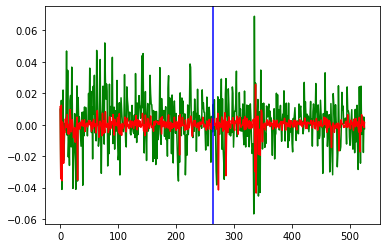

In [52]:
redicted = np.concatenate((trainPredict,testPredict),axis=0)

original = np.concatenate((trainY,testY),axis=0)
predicted = np.concatenate((trainPredict,testPredict),axis=0)
index = range(0, original.shape[0])
plt.plot(index,original, 'g')
plt.plot(index,predicted, 'r')
plt.axvline(df.index[train_size], c="b")
plt.savefig('./mlp_regression_results.png')
plt.show()